In [3]:
#pip install pyathena

In [5]:
#pip install awswrangler 

In [6]:
import awswrangler as wr

In [7]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
import numpy as np

In [8]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name= 'analytics'
table_name = 'daily_check'

In [9]:
#Connection
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
df = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name};', conn)

/tmp/ipykernel_64/3429179766.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name};', conn)


In [10]:
###DS FOREX

In [11]:
forex_table = 'last_daily_forex'
df_forex = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{forex_table};', conn)

/tmp/ipykernel_64/1414375228.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_forex = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{forex_table};', conn)


In [12]:
df_forex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5125 entries, 0 to 5124
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   symbol          5125 non-null   object        
 1   max_feed_date   5125 non-null   datetime64[ns]
 2   max_feed_price  5125 non-null   float64       
 3   day             5125 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 160.3+ KB


In [13]:
df_forex.head()

,symbol,max_feed_date,max_feed_price,day
0,USDBRL,2021-05-09 23:58:25,5.2370,2021-05-09
1,USDGTQ,2021-05-09 23:58:25,7.6568,2021-05-09
2,USDPHP,2021-05-09 23:58:25,47.8825,2021-05-09
3,USDBRL,2021-06-15 23:58:28,5.0814,2021-06-15
4,USDINR,2021-06-15 23:58:28,73.3628,2021-06-15


In [14]:
df.head()

,payer,country,date,tx,amount
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,1,55.55
1,ARGENPER,PERU,2023-04-03,26,4203.70
2,NAFA,"GAMBIA, THE",2023-04-03,8,1086.50
3,WALDOS (APPRIZA),MEXICO,2023-08-31,14,4797.50
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,43,17493.00


In [15]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [16]:
# Grouping by 'payer' and 'country' concatenated for this level of granularity
df['payer_country'] = df['payer'] + '_' + df['country']

In [17]:
# Chequeo montos
df['amount'].sum()

25110624454.414898

In [18]:
def aging_filter(df):
    # Find the last date in the sample
    last_date_sample = df['date'].max()

    # Calculate the limit date, one day before the last date in the sample
    limit_date = last_date_sample - pd.Timedelta(days=1)

    # Find the first and last date per 'payer_country' and calculate total_amount and count
    result = (
        df.groupby('payer_country')
        .agg(
            first_date=('date', 'min'),
            last_date=('date', 'max'),
            total_amount=('amount', 'sum'),
            total_transactions=('tx', 'sum')  # Add this line for total_transactions
        )
        .reset_index()
    )

    # Calculate the 'age_payer' variable accurately using the calculated limit_date
    result['age_payer'] = ((limit_date - result['first_date']).dt.days / 30).round(2)

    # Calculate the 'active_payer' variable
    result['active_time'] = ((result['last_date'] - result['first_date']).dt.days / 30).round(2)

    # Calculate the 'inactive' variable
    result['inactive_time'] = ((limit_date - result['last_date']).dt.days / 30).round(2)

    # Sort the final DataFrame by 'total_amount' from highest to lowest
    result = result.sort_values(by='total_amount', ascending=False)

    # Filter the DataFrame based on conditions and return aging_universe
    aging_universe = result.loc[
        (result.age_payer >= 3) & 
        (result.inactive_time <= 3) & 
        (result.total_amount > 10000) & 
        (result.total_transactions > 50)
    ]

    return aging_universe

In [19]:
# Defining Universe
df = df[df['amount'] != 0] # Excluding 0 (flag A & Flag C), defined in EDA

df_aging = aging_filter(df) #Filtering 'payer_country' based on Aging notebook
df_filtered = df[df['payer_country'].isin(df_aging['payer_country'])] # Applying aging filters 

In [20]:
# Date format
df_filtered['date'] = pd.to_datetime(df_filtered['date']).dt.date

/tmp/ipykernel_64/1252395900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = pd.to_datetime(df_filtered['date']).dt.date


In [21]:
df_filtered['amount'].sum()

24309892564.971

In [22]:
df_filtered.head(3)

,payer,country,date,tx,amount,payer_country
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,1,55.55,TRANSFERTO - THUNES_BELGIUM
1,ARGENPER,PERU,2023-04-03,26,4203.70,ARGENPER_PERU
2,NAFA,"GAMBIA, THE",2023-04-03,8,1086.50,"NAFA_GAMBIA, THE"


In [23]:
df_filtered.shape

(87708, 6)

In [24]:
# CHEQUEO VALORES

In [25]:
df[df['country'] == 'MEXICO']['amount'].sum()

13655009099.176899

In [26]:
val1 = df_filtered[df_filtered['country'] == 'MEXICO']['amount'].sum()
val1

12910028578.262497

In [27]:
val2 = df[df['country'] == 'MEXICO']['amount'].sum() - df_filtered[df_filtered['country'] == 'MEXICO']['amount'].sum()
val2

744980520.914402

In [28]:
val2/val1

0.05770556714094165

In [29]:
df[df['payer_country'] == 'ELEKTRA (MEXICO)_MEXICO']['amount'].sum()

6397946743.728701

In [30]:
df_filtered[df_filtered['payer_country'] == 'ELEKTRA (MEXICO)_MEXICO']['amount'].sum()

6397946743.728701

In [31]:
df_filtered['country'].unique()

array(['BELGIUM', 'PERU', 'GAMBIA, THE', 'MEXICO', 'HONDURAS', 'NIGERIA',
       'ECUADOR', 'UNITED KINGDOM', 'BRAZIL', 'UNITED STATES',
       'PHILIPPINES', 'EL SALVADOR', 'NICARAGUA', 'GUATEMALA', 'BOLIVIA',
       'HAITI', 'DOMINICAN REPUBLIC', 'UNITED STATES (ATM & DEPOSITS)',
       'COLOMBIA', 'SIERRA LEONE', 'CHILE', 'ARGENTINA', 'BANGLADESH',
       'INDONESIA', 'MALAYSIA', 'GUINEA', 'CAMEROON', 'NEPAL', 'GHANA',
       'INDIA', 'THAILAND', 'FRANCE', 'BURKINA FASO', 'SPAIN', 'PORTUGAL',
       "COTE D'IVOIRE (IVORY COAST)", 'BENIN', 'SENEGAL', 'TOGO',
       'LIBERIA', 'GERMANY', 'JAMAICA', 'MALI', 'ITALY', 'COSTA RICA'],
      dtype=object)

In [32]:
### RATES ###
#df_rates=pd.read_csv('rates_completo.csv') # CHEQUEAR FUENTE DE ORIGEN (COMPLETO TRAE TODOS LOS DATOS DDE ORIGEN)
df_forex.head()

,symbol,max_feed_date,max_feed_price,day
0,USDBRL,2021-05-09 23:58:25,5.2370,2021-05-09
1,USDGTQ,2021-05-09 23:58:25,7.6568,2021-05-09
2,USDPHP,2021-05-09 23:58:25,47.8825,2021-05-09
3,USDBRL,2021-06-15 23:58:28,5.0814,2021-06-15
4,USDINR,2021-06-15 23:58:28,73.3628,2021-06-15


In [33]:
# Selecting columns & renaming
df_forex=df_forex.rename(columns={'day': 'date', 'max_feed_price': 'feed_price'})
df_forex=df_forex.loc[:,['date', 'feed_price', 'symbol']]

In [34]:
df_forex.head()

,date,feed_price,symbol
0,2021-05-09,5.2370,USDBRL
1,2021-05-09,7.6568,USDGTQ
2,2021-05-09,47.8825,USDPHP
3,2021-06-15,5.0814,USDBRL
4,2021-06-15,73.3628,USDINR


In [35]:
df_rates=df_forex.copy()

In [36]:
#df_rates['date'] = pd.to_datetime(df_rates['date']).dt.date
#df_rates['date'] = pd.to_datetime(df_rates['date'])

In [37]:
# AHORA hay continuidad de fechas (chequeado, 1023 datos por cada pais desde 01/01/2021 hasta el 21/10/2023)
df_rates['date'].min(), df_rates['date'].max()

(datetime.date(2021, 1, 1), datetime.date(2023, 10, 22))

In [38]:
# Function to keep last register, per day
import matplotlib.pyplot as plt
def get_closing_prices(data, start_date, end_date):
    # Convert the 'FEED_DATE' column to datetime type if it is not already
    data['date'] = pd.to_datetime(data['date'])

    # Filter by date range
    data_filtered = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

    # Sort by 'FEED_DATE' to ensure that the data is in chronological order
    data_filtered = data_filtered.sort_values(by='date')

    # Group by 'SYMBOL' and 'FEED_DATE', taking the last value of 'FEED_PRICE'
    data_grouped = data_filtered.groupby(['symbol', pd.Grouper(key='date', freq='D')])['feed_price'].last().reset_index()
    
 # Generate evolution plots for each SYMBOL
    for symbol in data_grouped['symbol'].unique():
        symbol_data = data_grouped[data_grouped['symbol'] == symbol]

        plt.figure(figsize=(10, 6))
        plt.plot(symbol_data['date'], symbol_data['feed_price'], label=symbol)
        plt.title(f'Closing prices evolution for {symbol}')
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.show()
    
    return data_grouped

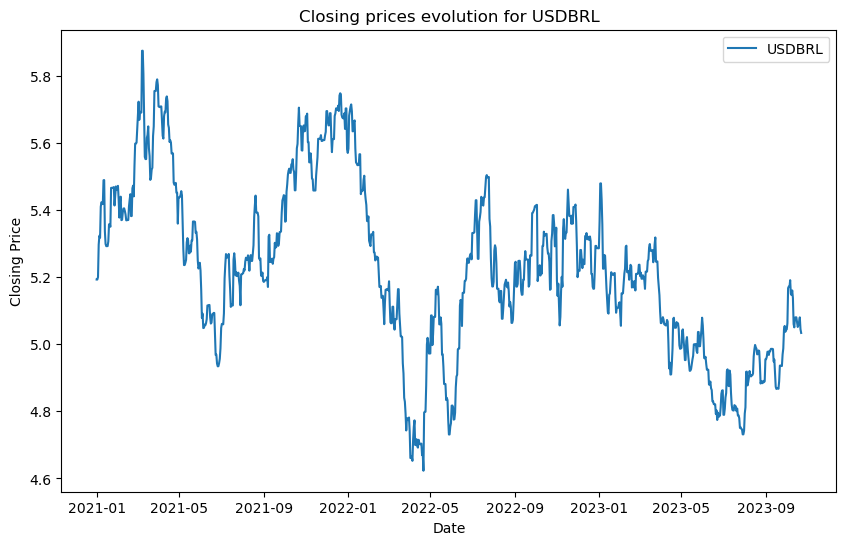

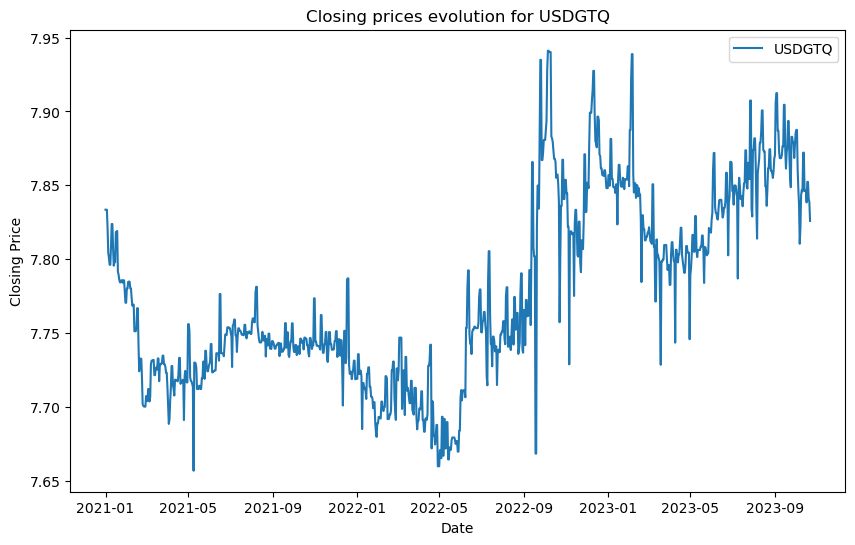

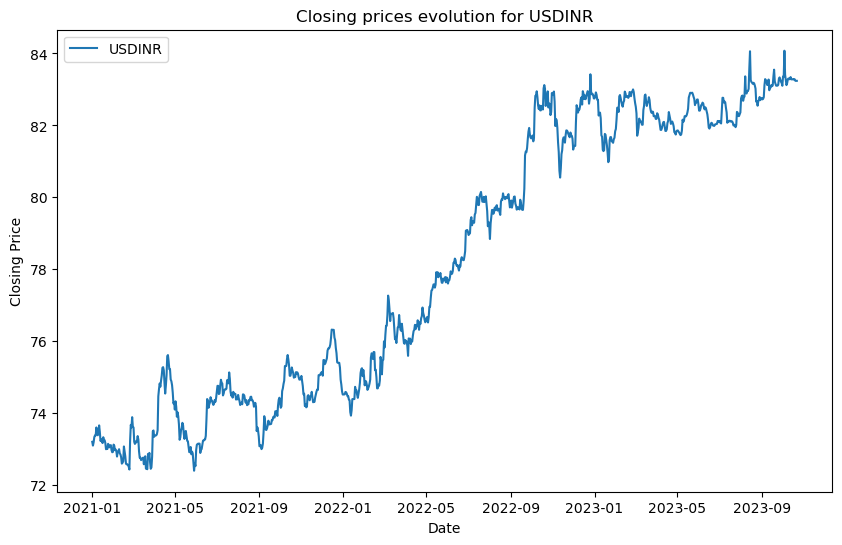

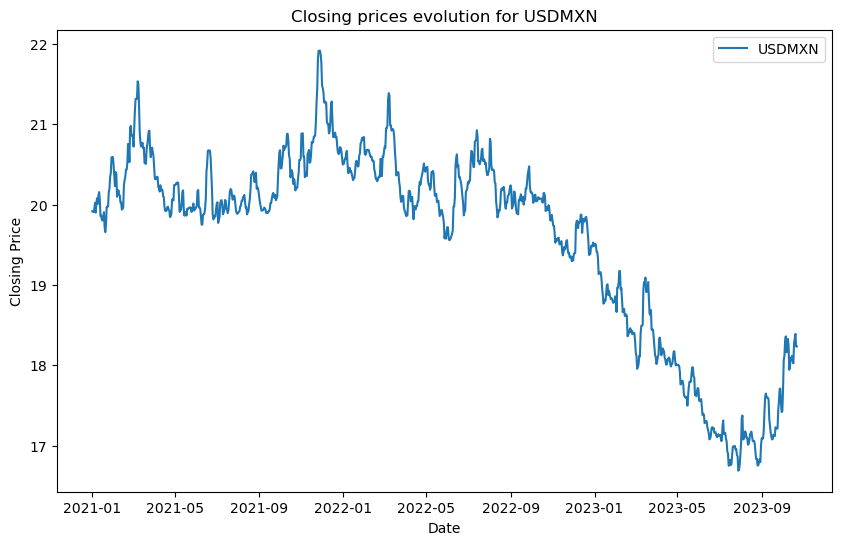

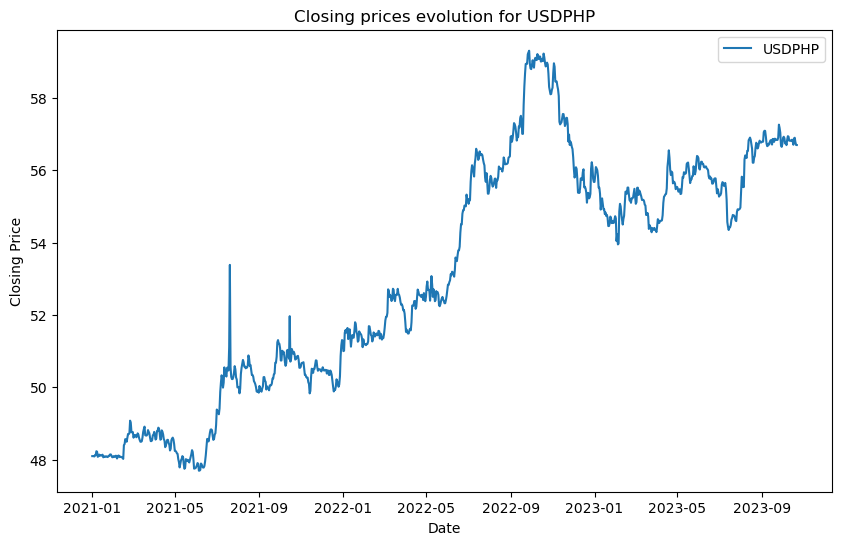

In [39]:
start_date = '2021-01-01'
end_date = '2023-10-22'

rates = get_closing_prices(df_rates, start_date, end_date)

In [40]:
rates.head(20)

,symbol,date,feed_price
0,USDBRL,2021-01-01,5.1935
1,USDBRL,2021-01-02,5.1934
2,USDBRL,2021-01-03,5.2008
3,USDBRL,2021-01-04,5.2976
4,USDBRL,2021-01-05,5.3244
5,USDBRL,2021-01-06,5.3182
6,USDBRL,2021-01-07,5.4108
7,USDBRL,2021-01-08,5.4242
8,USDBRL,2021-01-09,5.4206
9,USDBRL,2021-01-10,5.4186


In [41]:
#Date format
#rates['date'] = rates['date'].dt.date

In [42]:
# Generating an empty df with date continuity and currency included in rates df
from itertools import product

def generate_continuous_dates(data):
    # Obtener la lista única de monedas y fechas disponibles
    countries = data['symbol'].unique()
    dates = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='D')

    # Generar todas las combinaciones de países y fechas continuas
    all_dates = list(product(countries, dates))
    continuous_dates = pd.DataFrame(all_dates, columns=['symbol', 'date'])

    return continuous_dates

In [43]:
rates_cont = generate_continuous_dates(rates)

In [44]:
##1025 days x 5 countries= 5125
rates_cont.shape

(5125, 2)

In [45]:
rates_cont.date.min(), rates_cont.date.max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2023-10-22 00:00:00'))

In [46]:
rates_cont.isna().sum()

symbol    0
date      0
dtype: int64

In [47]:
rates_cont = pd.merge(rates_cont, rates, on=['symbol', 'date'], how='left')

In [48]:
rates_cont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5125 entries, 0 to 5124
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   symbol      5125 non-null   object        
 1   date        5125 non-null   datetime64[ns]
 2   feed_price  5125 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 120.2+ KB


In [49]:
#NOW IT MAKES NO SENSE SINCE THERE ARE NO MISSINGS
# Sorting by date and country for proper forward filling
rates_cont = rates_cont.sort_values(by=['symbol', 'date'])
# Filling missing values downward within each country group
rates_cont['feed_price'] = rates_cont.groupby('symbol')['feed_price'].fillna(method='ffill')

/tmp/ipykernel_64/305076726.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rates_cont['feed_price'] = rates_cont.groupby('symbol')['feed_price'].fillna(method='ffill')


In [50]:
rates_cont.head()

,symbol,date,feed_price
0,USDBRL,2021-01-01,5.1935
1,USDBRL,2021-01-02,5.1934
2,USDBRL,2021-01-03,5.2008
3,USDBRL,2021-01-04,5.2976
4,USDBRL,2021-01-05,5.3244


In [51]:
###WE OBTAIN THE LAGS OF UP TO 7 DAYS FOR THE EXCHANGE RATE 
for i in range(1, 8):
        nombre_columna = f'feed_price_retardo_{i}'
        rates_cont[nombre_columna] = rates_cont.groupby('symbol')['feed_price'].shift(i)

In [52]:
rates_cont.head()

,symbol,date,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
0,USDBRL,2021-01-01,5.1935,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USDBRL,2021-01-02,5.1934,5.1935,NaN,NaN,NaN,NaN,NaN,NaN
2,USDBRL,2021-01-03,5.2008,5.1934,5.1935,NaN,NaN,NaN,NaN,NaN
3,USDBRL,2021-01-04,5.2976,5.2008,5.1934,5.1935,NaN,NaN,NaN,NaN
4,USDBRL,2021-01-05,5.3244,5.2976,5.2008,5.1934,5.1935,NaN,NaN,NaN


In [53]:
rates_cont['var_rate_lag1']=rates_cont.feed_price_retardo_1-rates_cont.feed_price_retardo_2
rates_cont['var_rate_lag2']=rates_cont.feed_price_retardo_2-rates_cont.feed_price_retardo_3
rates_cont['var_rate_lag3']=rates_cont.feed_price_retardo_3-rates_cont.feed_price_retardo_4
rates_cont['var_rate_lag4']=rates_cont.feed_price_retardo_4-rates_cont.feed_price_retardo_5
rates_cont['var_rate_lag5']=rates_cont.feed_price_retardo_5-rates_cont.feed_price_retardo_6
rates_cont['var_rate_lag6']=rates_cont.feed_price_retardo_6-rates_cont.feed_price_retardo_7

In [54]:
rates_cont.head()

,symbol,date,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
0,USDBRL,2021-01-01,5.1935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USDBRL,2021-01-02,5.1934,5.1935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USDBRL,2021-01-03,5.2008,5.1934,5.1935,NaN,NaN,NaN,NaN,NaN,-0.0001,NaN,NaN,NaN,NaN,NaN
3,USDBRL,2021-01-04,5.2976,5.2008,5.1934,5.1935,NaN,NaN,NaN,NaN,0.0074,-0.0001,NaN,NaN,NaN,NaN
4,USDBRL,2021-01-05,5.3244,5.2976,5.2008,5.1934,5.1935,NaN,NaN,NaN,0.0968,0.0074,-0.0001,NaN,NaN,NaN


In [55]:
# Filling NaN?
rates_cont.isna().sum()
#rates_cont=rates_cont.fillna(method='bfill')
#rates_cont=rates_cont.fillna(method='ffill')

symbol                   0
date                     0
feed_price               0
feed_price_retardo_1     5
feed_price_retardo_2    10
feed_price_retardo_3    15
feed_price_retardo_4    20
feed_price_retardo_5    25
feed_price_retardo_6    30
feed_price_retardo_7    35
var_rate_lag1           10
var_rate_lag2           15
var_rate_lag3           20
var_rate_lag4           25
var_rate_lag5           30
var_rate_lag6           35
dtype: int64

In [56]:
rates_dict = {
    'USDBRL': 'BRAZIL', # Bz Real 
    'USDINR': 'INDIA', # Indian Rupia
    'USDGTQ': 'GUATEMALA', #Quetzal 
    'USDMXN': 'MEXICO', #Mx Peso
    'USDPHP': 'PHILIPPINES' # Ph Peso
}

In [57]:
rates_cont['country'] = rates_cont['symbol'].map(rates_dict)

In [58]:
rates_cont['country'].unique()

array(['BRAZIL', 'GUATEMALA', 'INDIA', 'MEXICO', 'PHILIPPINES'],
      dtype=object)

In [59]:
rates_cont

,symbol,date,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6,country
0,USDBRL,2021-01-01,5.1935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRAZIL
1,USDBRL,2021-01-02,5.1934,5.1935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRAZIL
2,USDBRL,2021-01-03,5.2008,5.1934,5.1935,NaN,NaN,NaN,NaN,NaN,-0.0001,NaN,NaN,NaN,NaN,NaN,BRAZIL
3,USDBRL,2021-01-04,5.2976,5.2008,5.1934,5.1935,NaN,NaN,NaN,NaN,0.0074,-0.0001,NaN,NaN,NaN,NaN,BRAZIL
4,USDBRL,2021-01-05,5.3244,5.2976,5.2008,5.1934,5.1935,NaN,NaN,NaN,0.0968,0.0074,-0.0001,NaN,NaN,NaN,BRAZIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5120,USDPHP,2023-10-18,56.8872,56.7100,56.8185,56.8485,56.8095,56.8227,56.8275,56.8185,-0.1085,-0.0300,0.0390,-0.0132,-0.0048,0.0090,PHILIPPINES
5121,USDPHP,2023-10-19,56.9022,56.8872,56.7100,56.8185,56.8485,56.8095,56.8227,56.8275,0.1772,-0.1085,-0.0300,0.0390,-0.0132,-0.0048,PHILIPPINES
5122,USDPHP,2023-10-20,56.7786,56.9022,56.8872,56.7100,56.8185,56.8485,56.8095,56.8227,0.0150,0.1772,-0.1085,-0.0300,0.0390,-0.0132,PHILIPPINES
5123,USDPHP,2023-10-21,56.7010,56.7786,56.9022,56.8872,56.7100,56.8185,56.8485,56.8095,-0.1236,0.0150,0.1772,-0.1085,-0.0300,0.0390,PHILIPPINES


In [60]:
df_filtered

,payer,country,date,tx,amount,payer_country
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,1,55.55,TRANSFERTO - THUNES_BELGIUM
1,ARGENPER,PERU,2023-04-03,26,4203.70,ARGENPER_PERU
2,NAFA,"GAMBIA, THE",2023-04-03,8,1086.50,"NAFA_GAMBIA, THE"
3,WALDOS (APPRIZA),MEXICO,2023-08-31,14,4797.50,WALDOS (APPRIZA)_MEXICO
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,43,17493.00,BANPAIS (RED CHAPINA)_HONDURAS
...,...,...,...,...,...,...
101965,ZEEPAY,GHANA,2023-07-10,104,44996.62,ZEEPAY_GHANA
101966,BANPRO,NICARAGUA,2021-12-02,238,68154.76,BANPRO_NICARAGUA
101967,MSBB MONEY,BRAZIL,2023-02-11,669,709461.62,MSBB MONEY_BRAZIL
101968,BANRURAL (RYT),GUATEMALA,2023-07-19,5338,2674853.77,BANRURAL (RYT)_GUATEMALA


In [61]:
#Date format
rates_cont['date'] = rates_cont['date'].dt.date

In [62]:
# Combined df  containing only the rows that match both the 'date' and 'country' columns in both df (df_filtered and rates).
# WARNING!!! Includes only common columns [date, country] > Check rates_dict
df1 = pd.merge(df_filtered, rates_cont, on=['date', 'country'], how='left')

In [63]:
df1['date'] = pd.to_datetime(df1['date']).dt.date

In [64]:
df1['amount'].sum()

24309892564.971

In [65]:
df1

,payer,country,date,tx,amount,payer_country,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,...,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,1,55.55,TRANSFERTO - THUNES_BELGIUM,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARGENPER,PERU,2023-04-03,26,4203.70,ARGENPER_PERU,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NAFA,"GAMBIA, THE",2023-04-03,8,1086.50,"NAFA_GAMBIA, THE",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WALDOS (APPRIZA),MEXICO,2023-08-31,14,4797.50,WALDOS (APPRIZA)_MEXICO,USDMXN,17.0076,16.7985,16.8354,...,16.7573,16.7544,16.8368,16.8350,-0.0369,0.0457,0.0324,0.0029,-0.0824,0.0018
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,43,17493.00,BANPAIS (RED CHAPINA)_HONDURAS,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87703,ZEEPAY,GHANA,2023-07-10,104,44996.62,ZEEPAY_GHANA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87704,BANPRO,NICARAGUA,2021-12-02,238,68154.76,BANPRO_NICARAGUA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87705,MSBB MONEY,BRAZIL,2023-02-11,669,709461.62,MSBB MONEY_BRAZIL,USDBRL,5.2156,5.2945,5.2914,...,5.2111,5.1815,5.1523,5.1525,0.0031,0.0653,0.0150,0.0296,0.0292,-0.0002
87706,BANRURAL (RYT),GUATEMALA,2023-07-19,5338,2674853.77,BANRURAL (RYT)_GUATEMALA,USDGTQ,7.8522,7.8511,7.8446,...,7.8425,7.8425,7.8407,7.8496,0.0065,0.0088,-0.0067,0.0000,0.0018,-0.0089


In [169]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87708 entries, 0 to 87707
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   payer                 87708 non-null  object        
 1   country               87708 non-null  object        
 2   date                  87708 non-null  datetime64[ns]
 3   tx                    87708 non-null  int64         
 4   amount                87708 non-null  float64       
 5   payer_country         87708 non-null  object        
 6   symbol                33780 non-null  object        
 7   feed_price            33780 non-null  float64       
 8   feed_price_retardo_1  33756 non-null  float64       
 9   feed_price_retardo_2  33730 non-null  float64       
 10  feed_price_retardo_3  33701 non-null  float64       
 11  feed_price_retardo_4  33673 non-null  float64       
 12  feed_price_retardo_5  33644 non-null  float64       
 13  feed_price_retar

In [66]:
### EFFECT OF CANCELED TRANSACTIONS ###

In [235]:
table2_name = 'daily_sales_count_cancelled_v2'##WE LOAD THE BASE WITH CANCELLATIONS
df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table2_name};', conn)

/tmp/ipykernel_64/1193640667.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table2_name};', conn)


In [236]:
df2['date'] = pd.to_datetime(df2['date'])

In [238]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101970 entries, 0 to 101969
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   payer         101970 non-null  object        
 1   country       101970 non-null  object        
 2   date          101970 non-null  datetime64[ns]
 3   amount        101970 non-null  float64       
 4   tx_cancelled  101970 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 3.9+ MB


In [239]:
df2.head()

,payer,country,date,amount,tx_cancelled
0,BBVA - BANCOMER (BTS),MEXICO,2022-04-09,721684.70,64
1,INTERMEX,MEXICO,2022-04-09,312692.44,47
2,ECUAGIROS,ECUADOR,2022-05-13,51985.54,20
3,TELEDOLAR,COSTA RICA,2022-04-12,57395.00,12
4,ARGENPER,ARGENTINA,2022-04-12,1093.00,0


In [240]:
###ORDERED BY: COUNTRY, PAYER, DATE

In [241]:
df2=df2.sort_values(by=['country', 'payer', 'date'])

In [242]:
df2.head()

,payer,country,date,amount,tx_cancelled
8766,AFEX,ARGENTINA,2021-08-05,0.0,1
864,AFEX,ARGENTINA,2021-08-06,0.0,1
51311,ARGENPER,ARGENTINA,2020-12-31,70.0,0
21786,ARGENPER,ARGENTINA,2021-01-02,25.0,0
9590,ARGENPER,ARGENTINA,2021-01-05,490.0,0


In [243]:
###HERE WE NEED TO ADD MISSING DAYS IN PAYERS WITH FEW TRANSACTIONS AND IMPUTE ZERO IN CANCELLATIONS

In [244]:
# Contar las combinaciones únicas de payer y country
combinaciones_unicas = df2.groupby(['payer', 'country']).size().reset_index(name='conteo_combinaciones')
# Mostrar el resultado
print(combinaciones_unicas)

             payer                      country  conteo_combinaciones
0           24XORO                       MEXICO                   225
1    7 ELEVEN (UT)                       MEXICO                   206
2       ABANK (TN)                  EL SALVADOR                  1025
3             AFEX                    ARGENTINA                     2
4             AFEX                        CHILE                  1013
..             ...                          ...                   ...
294         ZEEPAY                     CAMEROON                   402
295         ZEEPAY  COTE D'IVOIRE (IVORY COAST)                   352
296         ZEEPAY                        GHANA                  1025
297         ZEEPAY                       GUINEA                    11
298         ZEEPAY                      SENEGAL                   284

[299 rows x 3 columns]


In [245]:
# Grouping by 'payer' and 'country' concatenated for this level of granularity
df2['payer_country'] = df2['payer'] + '_' + df2['country']

In [246]:
##### Filtro por aging nuevamente ####
######################################

df2 = df2[df2['payer_country'].isin(df_aging['payer_country'])] # Applying aging filters 

In [247]:
### Combining payer and country, we can obtain a column to work on 
# We can enconde it to obtain better results
from sklearn.preprocessing import LabelEncoder
# Inicializar LabelEncoder
label_encoder = LabelEncoder()
# Codificar ‘PAYER_COUNTRY’ como valores numéricos únicos
df2['payer_country_encoder'] = label_encoder.fit_transform(df2['payer_country'])

In [248]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89492 entries, 51311 to 17284
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   payer                  89492 non-null  object        
 1   country                89492 non-null  object        
 2   date                   89492 non-null  datetime64[ns]
 3   amount                 89492 non-null  float64       
 4   tx_cancelled           89492 non-null  int64         
 5   payer_country          89492 non-null  object        
 6   payer_country_encoder  89492 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.5+ MB


In [249]:
### CHEQUEAR QUE SIEMPRE ASIGNE EL MISMO CODIGO A CADA PAYER EN LA IMPLEMENTACIÓN!!!!!!!!!!##

In [250]:
# Crear un rango de fechas desde el 1 de enero de 2021 hasta el 21 de octubre de 2023
date_range = pd.date_range(start='2021-01-01', end='2023-10-21', freq='D')

# Crear un DataFrame con todas las combinaciones posibles de 'date' y 'payer_country_encoder'
all_combinations = pd.MultiIndex.from_product([date_range, df2['payer_country_encoder'].unique()], names=['date', 'payer_country_encoder'])
all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()

# Combinar el DataFrame completo con tu DataFrame original
df_completo = pd.merge(all_combinations_df, df2, how='left', on=['date', 'payer_country_encoder'])



In [251]:
df_completo.shape

(133120, 7)

In [252]:
###HERE WE NEED TO ADD MISSING DAYS IN PAYERS WITH FEW TRANSACTIONS AND IMPUTE ZERO IN CANCELLATIONS

In [253]:
df_completo.shape

(133120, 7)

In [254]:
df_completo.payer_country_encoder.nunique()

130

In [255]:
df_completo=df_completo.sort_values(by=['payer_country_encoder', 'date'])

In [256]:
df_control=df_completo.loc[df_completo.payer_country_encoder==3]
df_control.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1024 entries, 55 to 133045
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1024 non-null   datetime64[ns]
 1   payer_country_encoder  1024 non-null   int64         
 2   payer                  246 non-null    object        
 3   country                246 non-null    object        
 4   amount                 246 non-null    float64       
 5   tx_cancelled           246 non-null    float64       
 6   payer_country          246 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 64.0+ KB


In [257]:
##WE CHECK THAT FOR THE CASE WITH ONLY TWO MOVEMENTS THE WHOLE SERIES APPEARS
df_filt = df_control[df_control.notnull().all(axis=1)]
df_filt

,date,payer_country_encoder,payer,country,amount,tx_cancelled,payer_country
31905,2021-09-03,3,AFRO INTERNACIONAL,GUINEA,0.0,1.0,AFRO INTERNACIONAL_GUINEA
32035,2021-09-04,3,AFRO INTERNACIONAL,GUINEA,620.0,0.0,AFRO INTERNACIONAL_GUINEA
32295,2021-09-06,3,AFRO INTERNACIONAL,GUINEA,0.0,1.0,AFRO INTERNACIONAL_GUINEA
35805,2021-10-03,3,AFRO INTERNACIONAL,GUINEA,600.0,0.0,AFRO INTERNACIONAL_GUINEA
37495,2021-10-16,3,AFRO INTERNACIONAL,GUINEA,0.0,1.0,AFRO INTERNACIONAL_GUINEA
...,...,...,...,...,...,...,...
131485,2023-10-09,3,AFRO INTERNACIONAL,GUINEA,100.0,0.0,AFRO INTERNACIONAL_GUINEA
132005,2023-10-13,3,AFRO INTERNACIONAL,GUINEA,500.0,0.0,AFRO INTERNACIONAL_GUINEA
132135,2023-10-14,3,AFRO INTERNACIONAL,GUINEA,100.0,0.0,AFRO INTERNACIONAL_GUINEA
132525,2023-10-17,3,AFRO INTERNACIONAL,GUINEA,200.0,0.0,AFRO INTERNACIONAL_GUINEA


In [258]:
df_completo.head(30)

,date,payer_country_encoder,payer,country,amount,tx_cancelled,payer_country
78,2021-01-01,0,NaN,NaN,NaN,NaN,NaN
208,2021-01-02,0,NaN,NaN,NaN,NaN,NaN
338,2021-01-03,0,NaN,NaN,NaN,NaN,NaN
468,2021-01-04,0,NaN,NaN,NaN,NaN,NaN
598,2021-01-05,0,NaN,NaN,NaN,NaN,NaN
728,2021-01-06,0,NaN,NaN,NaN,NaN,NaN
858,2021-01-07,0,NaN,NaN,NaN,NaN,NaN
988,2021-01-08,0,NaN,NaN,NaN,NaN,NaN
1118,2021-01-09,0,NaN,NaN,NaN,NaN,NaN
1248,2021-01-10,0,NaN,NaN,NaN,NaN,NaN


In [259]:
###CONTROL EXTRA
df_control2=df_completo.loc[df_completo.payer=='ELEKTRA (MEXICO)']
df_control2.amount.sum()

6395528397.018701

In [260]:
del df2
df2=df_completo.copy()

In [261]:
###ORDERED BY COUNTRY PAYER AND DATE

In [262]:
df2=df2.sort_values(by=['country', 'payer', 'date'])

In [263]:
df2.head()

,date,payer_country_encoder,payer,country,amount,tx_cancelled,payer_country
130,2021-01-02,6,ARGENPER,ARGENTINA,25.0,0.0,ARGENPER_ARGENTINA
520,2021-01-05,6,ARGENPER,ARGENTINA,490.0,0.0,ARGENPER_ARGENTINA
1430,2021-01-12,6,ARGENPER,ARGENTINA,150.0,0.0,ARGENPER_ARGENTINA
1950,2021-01-16,6,ARGENPER,ARGENTINA,50.0,0.0,ARGENPER_ARGENTINA
2210,2021-01-18,6,ARGENPER,ARGENTINA,200.0,0.0,ARGENPER_ARGENTINA


In [264]:
###IT IS NECESSARY TO FILL THE MISSING COUNTRY AND DATE FIELDS WITH THE ENCODER ID AND THEN FILL MISSINGS AMOUNT AND TX_CANCELLED WITH ZERO.

In [265]:
df2['payer'] = df2.groupby('payer_country_encoder')['payer'].fillna(method='ffill')
df2['country'] = df2.groupby('payer_country_encoder')['country'].fillna(method='ffill')
df2['payer_country'] = df2.groupby('payer_country_encoder')['payer_country'].fillna(method='ffill')

/tmp/ipykernel_64/3419388508.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2['payer'] = df2.groupby('payer_country_encoder')['payer'].fillna(method='ffill')
/tmp/ipykernel_64/3419388508.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2['country'] = df2.groupby('payer_country_encoder')['country'].fillna(method='ffill')
/tmp/ipykernel_64/3419388508.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2['payer_country'] = df2.groupby('payer_country_encoder')['payer_country'].fillna(method='ffill')


In [266]:
df_control=df2.loc[df2.payer_country_encoder==3]
df_control.head()

,date,payer_country_encoder,payer,country,amount,tx_cancelled,payer_country
31905,2021-09-03,3,AFRO INTERNACIONAL,GUINEA,0.0,1.0,AFRO INTERNACIONAL_GUINEA
32035,2021-09-04,3,AFRO INTERNACIONAL,GUINEA,620.0,0.0,AFRO INTERNACIONAL_GUINEA
32295,2021-09-06,3,AFRO INTERNACIONAL,GUINEA,0.0,1.0,AFRO INTERNACIONAL_GUINEA
35805,2021-10-03,3,AFRO INTERNACIONAL,GUINEA,600.0,0.0,AFRO INTERNACIONAL_GUINEA
37495,2021-10-16,3,AFRO INTERNACIONAL,GUINEA,0.0,1.0,AFRO INTERNACIONAL_GUINEA


In [267]:
df_control.shape

(1024, 7)

In [268]:
##NOW WE FILL WITH ZEROS THE MISSINGS IN AMOUNT AND TX_CANCELLED

In [269]:
df2['amount'] = df2['amount'].fillna(0)
df2['tx_cancelled'] = df2['tx_cancelled'].fillna(0)

In [270]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133120 entries, 130 to 133013
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   133120 non-null  datetime64[ns]
 1   payer_country_encoder  133120 non-null  int64         
 2   payer                  133120 non-null  object        
 3   country                133120 non-null  object        
 4   amount                 133120 non-null  float64       
 5   tx_cancelled           133120 non-null  float64       
 6   payer_country          133120 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 8.1+ MB


In [271]:
##ONCE THE DATASET HAS BEEN SORTED, WE CAN OBTAIN THE LAGS OF THE CANCELLED TX

In [272]:
df2=df2.sort_values(by=['country', 'payer', 'date'])

In [273]:
for i in range(1, 8):
    nombre_columna = f'tx_cancelled_{i}'
    df2[nombre_columna] = df2.groupby(['country', 'payer'])['tx_cancelled'].shift(i)

In [274]:
##NOTE THAT IT BRINGS THE NUMBER OF CANCELLATIONS FOR THE LAST AVAILABLE DATA (I.E. THE PREVIOUS ROW)
df_prueba=df2.loc[df2.country=='MEXICO']
df_prueba.tail(20)

,date,payer_country_encoder,payer,country,amount,tx_cancelled,payer_country,tx_cancelled_1,tx_cancelled_2,tx_cancelled_3,tx_cancelled_4,tx_cancelled_5,tx_cancelled_6,tx_cancelled_7
130618,2023-10-02,125,WALMART (UT),MEXICO,415628.29,54.0,WALMART (UT)_MEXICO,48.0,62.0,51.0,34.0,56.0,42.0,55.0
130748,2023-10-03,125,WALMART (UT),MEXICO,352194.74,64.0,WALMART (UT)_MEXICO,54.0,48.0,62.0,51.0,34.0,56.0,42.0
130878,2023-10-04,125,WALMART (UT),MEXICO,341639.25,74.0,WALMART (UT)_MEXICO,64.0,54.0,48.0,62.0,51.0,34.0,56.0
131008,2023-10-05,125,WALMART (UT),MEXICO,473442.39,61.0,WALMART (UT)_MEXICO,74.0,64.0,54.0,48.0,62.0,51.0,34.0
131138,2023-10-06,125,WALMART (UT),MEXICO,605532.85,46.0,WALMART (UT)_MEXICO,61.0,74.0,64.0,54.0,48.0,62.0,51.0
131268,2023-10-07,125,WALMART (UT),MEXICO,597892.70,42.0,WALMART (UT)_MEXICO,46.0,61.0,74.0,64.0,54.0,48.0,62.0
131398,2023-10-08,125,WALMART (UT),MEXICO,438368.94,56.0,WALMART (UT)_MEXICO,42.0,46.0,61.0,74.0,64.0,54.0,48.0
131528,2023-10-09,125,WALMART (UT),MEXICO,331874.13,32.0,WALMART (UT)_MEXICO,56.0,42.0,46.0,61.0,74.0,64.0,54.0
131658,2023-10-10,125,WALMART (UT),MEXICO,310515.78,46.0,WALMART (UT)_MEXICO,32.0,56.0,42.0,46.0,61.0,74.0,64.0
131788,2023-10-11,125,WALMART (UT),MEXICO,265200.61,39.0,WALMART (UT)_MEXICO,46.0,32.0,56.0,42.0,46.0,61.0,74.0


In [276]:
###CONTROL 
df_control3=df2.loc[df2.payer=='ELEKTRA (MEXICO)']
df_control3.head()

,date,payer_country_encoder,payer,country,amount,tx_cancelled,payer_country,tx_cancelled_1,tx_cancelled_2,tx_cancelled_3,tx_cancelled_4,tx_cancelled_5,tx_cancelled_6,tx_cancelled_7
85,2021-01-01,57,ELEKTRA (MEXICO),MEXICO,717241.42,94.0,ELEKTRA (MEXICO)_MEXICO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,2021-01-02,57,ELEKTRA (MEXICO),MEXICO,3360407.85,358.0,ELEKTRA (MEXICO)_MEXICO,94.0,NaN,NaN,NaN,NaN,NaN,NaN
345,2021-01-03,57,ELEKTRA (MEXICO),MEXICO,2767481.77,278.0,ELEKTRA (MEXICO)_MEXICO,358.0,94.0,NaN,NaN,NaN,NaN,NaN
475,2021-01-04,57,ELEKTRA (MEXICO),MEXICO,3621953.17,323.0,ELEKTRA (MEXICO)_MEXICO,278.0,358.0,94.0,NaN,NaN,NaN,NaN
605,2021-01-05,57,ELEKTRA (MEXICO),MEXICO,2862477.96,289.0,ELEKTRA (MEXICO)_MEXICO,323.0,278.0,358.0,94.0,NaN,NaN,NaN


In [225]:
##NOW WE CAN GENERATE THE VARIATIONS IN THE CANCELLED TX

In [277]:
df2['var_tx_cancelled_1']=df2.tx_cancelled_1-df2.tx_cancelled_2
df2['var_tx_cancelled_2']=df2.tx_cancelled_2-df2.tx_cancelled_3
df2['var_tx_cancelled_3']=df2.tx_cancelled_3-df2.tx_cancelled_4
df2['var_tx_cancelled_4']=df2.tx_cancelled_4-df2.tx_cancelled_5
df2['var_tx_cancelled_5']=df2.tx_cancelled_5-df2.tx_cancelled_6
df2['var_tx_cancelled_6']=df2.tx_cancelled_6-df2.tx_cancelled_7

In [278]:
df2.head()

,date,payer_country_encoder,payer,country,amount,tx_cancelled,payer_country,tx_cancelled_1,tx_cancelled_2,tx_cancelled_3,tx_cancelled_4,tx_cancelled_5,tx_cancelled_6,tx_cancelled_7,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6
0,2021-01-01,6,ARGENPER,ARGENTINA,0.0,0.0,ARGENPER_ARGENTINA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,2021-01-02,6,ARGENPER,ARGENTINA,25.0,0.0,ARGENPER_ARGENTINA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,2021-01-03,6,ARGENPER,ARGENTINA,0.0,0.0,ARGENPER_ARGENTINA,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
390,2021-01-04,6,ARGENPER,ARGENTINA,0.0,0.0,ARGENPER_ARGENTINA,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
520,2021-01-05,6,ARGENPER,ARGENTINA,490.0,0.0,ARGENPER_ARGENTINA,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN


In [279]:
df_prueba2=df2.loc[df2.payer=='ELEKTRA (MEXICO)']
df_prueba2.head()

,date,payer_country_encoder,payer,country,amount,tx_cancelled,payer_country,tx_cancelled_1,tx_cancelled_2,tx_cancelled_3,tx_cancelled_4,tx_cancelled_5,tx_cancelled_6,tx_cancelled_7,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6
85,2021-01-01,57,ELEKTRA (MEXICO),MEXICO,717241.42,94.0,ELEKTRA (MEXICO)_MEXICO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,2021-01-02,57,ELEKTRA (MEXICO),MEXICO,3360407.85,358.0,ELEKTRA (MEXICO)_MEXICO,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
345,2021-01-03,57,ELEKTRA (MEXICO),MEXICO,2767481.77,278.0,ELEKTRA (MEXICO)_MEXICO,358.0,94.0,NaN,NaN,NaN,NaN,NaN,264.0,NaN,NaN,NaN,NaN,NaN
475,2021-01-04,57,ELEKTRA (MEXICO),MEXICO,3621953.17,323.0,ELEKTRA (MEXICO)_MEXICO,278.0,358.0,94.0,NaN,NaN,NaN,NaN,-80.0,264.0,NaN,NaN,NaN,NaN
605,2021-01-05,57,ELEKTRA (MEXICO),MEXICO,2862477.96,289.0,ELEKTRA (MEXICO)_MEXICO,323.0,278.0,358.0,94.0,NaN,NaN,NaN,45.0,-80.0,264.0,NaN,NaN,NaN


In [280]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133120 entries, 0 to 133119
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   133120 non-null  datetime64[ns]
 1   payer_country_encoder  133120 non-null  int64         
 2   payer                  133120 non-null  object        
 3   country                133120 non-null  object        
 4   amount                 133120 non-null  float64       
 5   tx_cancelled           133120 non-null  float64       
 6   payer_country          133120 non-null  object        
 7   tx_cancelled_1         132990 non-null  float64       
 8   tx_cancelled_2         132860 non-null  float64       
 9   tx_cancelled_3         132730 non-null  float64       
 10  tx_cancelled_4         132600 non-null  float64       
 11  tx_cancelled_5         132470 non-null  float64       
 12  tx_cancelled_6         132340 non-null  float64  

In [281]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87708 entries, 0 to 87707
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   payer                 87708 non-null  object        
 1   country               87708 non-null  object        
 2   date                  87708 non-null  datetime64[ns]
 3   tx                    87708 non-null  int64         
 4   amount                87708 non-null  float64       
 5   payer_country         87708 non-null  object        
 6   symbol                33780 non-null  object        
 7   feed_price            33780 non-null  float64       
 8   feed_price_retardo_1  33756 non-null  float64       
 9   feed_price_retardo_2  33730 non-null  float64       
 10  feed_price_retardo_3  33701 non-null  float64       
 11  feed_price_retardo_4  33673 non-null  float64       
 12  feed_price_retardo_5  33644 non-null  float64       
 13  feed_price_retar

In [282]:
df1['date'] = pd.to_datetime(df1['date'])

In [283]:
df_final = pd.merge(df1,df2, on=['date','payer','country', 'amount'], how='outer')

In [284]:
df_final['date'] = pd.to_datetime(df_final['date'])

In [285]:
df_final['amount'].sum()

24309892564.971

In [286]:
df_final.shape

(133188, 37)

In [287]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133188 entries, 0 to 133187
Data columns (total 37 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   payer                  133188 non-null  object        
 1   country                133188 non-null  object        
 2   date                   133188 non-null  datetime64[ns]
 3   tx                     87708 non-null   float64       
 4   amount                 133188 non-null  float64       
 5   payer_country_x        87708 non-null   object        
 6   symbol                 33780 non-null   object        
 7   feed_price             33780 non-null   float64       
 8   feed_price_retardo_1   33756 non-null   float64       
 9   feed_price_retardo_2   33730 non-null   float64       
 10  feed_price_retardo_3   33701 non-null   float64       
 11  feed_price_retardo_4   33673 non-null   float64       
 12  feed_price_retardo_5   33644 non-null   floa

In [119]:
###WE SHOULD KEEP THE VARIABLES THAT HAVE IMPUTED MISSINGS IN AMOUNT AND TX_CANCELLED (DAYS WITHOUT OPERATIONS) BUT KEEP THE MISSINGS IN RATES
df_final=df_final.loc[:,['payer', 'country', 'date', 'amount', 'var_rate_lag1', 'var_rate_lag2','var_rate_lag3','var_rate_lag4','var_rate_lag5','var_rate_lag6','payer_country_encoder','payer_country_y','var_tx_cancelled_1','var_tx_cancelled_2','var_tx_cancelled_3','var_tx_cancelled_4','var_tx_cancelled_5','var_tx_cancelled_6',]]

In [120]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306244 entries, 0 to 306243
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   payer                  306244 non-null  object        
 1   country                306244 non-null  object        
 2   date                   306244 non-null  datetime64[ns]
 3   amount                 306244 non-null  float64       
 4   var_rate_lag1          33730 non-null   float64       
 5   var_rate_lag2          33701 non-null   float64       
 6   var_rate_lag3          33673 non-null   float64       
 7   var_rate_lag4          33644 non-null   float64       
 8   var_rate_lag5          33617 non-null   float64       
 9   var_rate_lag6          33589 non-null   float64       
 10  payer_country_encoder  306176 non-null  float64       
 11  payer_country_y        306176 non-null  object        
 12  var_tx_cancelled_1     305578 non-null  floa

In [121]:
df_final = df_final.rename(columns={'payer_country_y': 'payer_country'})
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306244 entries, 0 to 306243
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   payer                  306244 non-null  object        
 1   country                306244 non-null  object        
 2   date                   306244 non-null  datetime64[ns]
 3   amount                 306244 non-null  float64       
 4   var_rate_lag1          33730 non-null   float64       
 5   var_rate_lag2          33701 non-null   float64       
 6   var_rate_lag3          33673 non-null   float64       
 7   var_rate_lag4          33644 non-null   float64       
 8   var_rate_lag5          33617 non-null   float64       
 9   var_rate_lag6          33589 non-null   float64       
 10  payer_country_encoder  306176 non-null  float64       
 11  payer_country          306176 non-null  object        
 12  var_tx_cancelled_1     305578 non-null  floa

In [122]:
prueba3=df_final.loc[df_final.payer_country_encoder==80]
prueba3.head()

,payer,country,date,amount,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6,payer_country_encoder,payer_country,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6
37,ELEKTRA (BTS),GUATEMALA,2021-11-16,13897.26,0.0058,0.0000,-0.0071,-0.0185,0.0000,0.0234,80.0,ELEKTRA (BTS)_GUATEMALA,-2.0,4.0,-1.0,5.0,0.0,0.0
67,ELEKTRA (BTS),GUATEMALA,2022-12-07,32491.60,0.0221,0.0291,-0.0037,0.0000,0.0195,0.0004,80.0,ELEKTRA (BTS)_GUATEMALA,0.0,-2.0,-10.0,13.0,1.0,2.0
324,ELEKTRA (BTS),GUATEMALA,2021-03-27,30286.47,0.0000,0.0053,0.0000,0.0008,0.0000,0.0112,80.0,ELEKTRA (BTS)_GUATEMALA,0.0,-2.0,2.0,-5.0,5.0,-2.0
633,ELEKTRA (BTS),GUATEMALA,2022-02-10,11755.52,-0.0013,-0.0051,0.0000,0.0114,0.0000,-0.0010,80.0,ELEKTRA (BTS)_GUATEMALA,-4.0,-6.0,-1.0,5.0,7.0,-3.0
1208,ELEKTRA (BTS),GUATEMALA,2022-05-05,16326.87,-0.0053,-0.0001,0.0109,0.0000,0.0000,-0.0280,80.0,ELEKTRA (BTS)_GUATEMALA,0.0,0.0,-4.0,3.0,1.0,4.0


In [123]:
prueba3.sort_values(by='date')

,payer,country,date,amount,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6,payer_country_encoder,payer_country,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6
60754,ELEKTRA (BTS),GUATEMALA,2021-01-01,2641.00,NaN,NaN,NaN,NaN,NaN,NaN,80.0,ELEKTRA (BTS)_GUATEMALA,NaN,NaN,NaN,NaN,NaN,NaN
7328,ELEKTRA (BTS),GUATEMALA,2021-01-02,21629.37,NaN,NaN,NaN,NaN,NaN,NaN,80.0,ELEKTRA (BTS)_GUATEMALA,NaN,NaN,NaN,NaN,NaN,NaN
14100,ELEKTRA (BTS),GUATEMALA,2021-01-03,16843.00,0.0000,NaN,NaN,NaN,NaN,NaN,80.0,ELEKTRA (BTS)_GUATEMALA,5.0,NaN,NaN,NaN,NaN,NaN
59222,ELEKTRA (BTS),GUATEMALA,2021-01-04,13168.00,0.0000,0.0000,NaN,NaN,NaN,NaN,80.0,ELEKTRA (BTS)_GUATEMALA,-3.0,5.0,NaN,NaN,NaN,NaN
39011,ELEKTRA (BTS),GUATEMALA,2021-01-05,9639.00,-0.0124,0.0000,0.0000,NaN,NaN,NaN,80.0,ELEKTRA (BTS)_GUATEMALA,2.0,-3.0,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51271,ELEKTRA (BTS),GUATEMALA,2023-10-17,43037.53,0.0006,0.0000,-0.0260,0.0000,0.0262,-0.0010,80.0,ELEKTRA (BTS)_GUATEMALA,-8.0,-1.0,-11.0,10.0,16.0,-4.0
40800,ELEKTRA (BTS),GUATEMALA,2023-10-18,44745.00,-0.0083,0.0006,0.0000,-0.0260,0.0000,0.0262,80.0,ELEKTRA (BTS)_GUATEMALA,-3.0,-8.0,-1.0,-11.0,10.0,16.0
9574,ELEKTRA (BTS),GUATEMALA,2023-10-19,46259.04,0.0139,-0.0083,0.0006,0.0000,-0.0260,0.0000,80.0,ELEKTRA (BTS)_GUATEMALA,-4.0,-3.0,-8.0,-1.0,-11.0,10.0
68216,ELEKTRA (BTS),GUATEMALA,2023-10-20,74883.98,0.0000,0.0139,-0.0083,0.0006,0.0000,-0.0260,80.0,ELEKTRA (BTS)_GUATEMALA,-4.0,-4.0,-3.0,-8.0,-1.0,-11.0


In [124]:
##WE NEED TO KEEP IN THE SAMPLE ONLY THE CASES THAT MEET THE CONDITIONS TO BE IN THE DATA UNIVERSE.

In [125]:
df_filtered.payer_country.nunique()

130

In [126]:
df_filtered2=df_filtered.loc[:,['payer_country']]
df_filtered2 = df_filtered2.drop_duplicates(subset='payer_country', keep='first')
df_filtered2.shape

(130, 1)

In [127]:
df_final2=pd.merge(df_final,df_filtered2, on='payer_country', how='left', indicator=True)

In [128]:
df_final2._merge.value_counts()

_merge
left_only     173124
both          133120
right_only         0
Name: count, dtype: int64

In [129]:
df_final3=df_final2.loc[df_final2._merge=='both']
df_final3.amount.sum()

24303285928.466003

In [130]:
df_final3.shape

(133120, 19)

In [131]:
df_final3.head()

,payer,country,date,amount,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6,payer_country_encoder,payer_country,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6,_merge
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,55.55,NaN,NaN,NaN,NaN,NaN,NaN,227.0,TRANSFERTO - THUNES_BELGIUM,0.0,0.0,0.0,0.0,0.0,0.0,both
1,ARGENPER,PERU,2023-04-03,4203.70,NaN,NaN,NaN,NaN,NaN,NaN,12.0,ARGENPER_PERU,-6.0,0.0,0.0,3.0,-1.0,2.0,both
2,NAFA,"GAMBIA, THE",2023-04-03,1086.50,NaN,NaN,NaN,NaN,NaN,NaN,186.0,"NAFA_GAMBIA, THE",0.0,0.0,0.0,0.0,-1.0,1.0,both
3,WALDOS (APPRIZA),MEXICO,2023-08-31,4797.50,-0.0369,0.0457,0.0324,0.0029,-0.0824,0.0018,289.0,WALDOS (APPRIZA)_MEXICO,-1.0,0.0,-1.0,-1.0,3.0,-1.0,both
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,17493.00,NaN,NaN,NaN,NaN,NaN,NaN,41.0,BANPAIS (RED CHAPINA)_HONDURAS,-2.0,5.0,0.0,-2.0,-1.0,3.0,both


In [138]:
df_final3

,payer,country,date,amount,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6,payer_country_encoder,payer_country,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6,_merge,weekday
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,55.55,NaN,NaN,NaN,NaN,NaN,NaN,227.0,TRANSFERTO - THUNES_BELGIUM,0.0,0.0,0.0,0.0,0.0,0.0,both,1
1,ARGENPER,PERU,2023-04-03,4203.70,NaN,NaN,NaN,NaN,NaN,NaN,12.0,ARGENPER_PERU,-6.0,0.0,0.0,3.0,-1.0,2.0,both,1
2,NAFA,"GAMBIA, THE",2023-04-03,1086.50,NaN,NaN,NaN,NaN,NaN,NaN,186.0,"NAFA_GAMBIA, THE",0.0,0.0,0.0,0.0,-1.0,1.0,both,1
3,WALDOS (APPRIZA),MEXICO,2023-08-31,4797.50,-0.0369,0.0457,0.0324,0.0029,-0.0824,0.0018,289.0,WALDOS (APPRIZA)_MEXICO,-1.0,0.0,-1.0,-1.0,3.0,-1.0,both,1
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,17493.00,NaN,NaN,NaN,NaN,NaN,NaN,41.0,BANPAIS (RED CHAPINA)_HONDURAS,-2.0,5.0,0.0,-2.0,-1.0,3.0,both,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300095,VIAMERICAS USA DEPOSITS,UNITED STATES (ATM & DEPOSITS),2023-10-17,0.00,NaN,NaN,NaN,NaN,NaN,NaN,287.0,VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & D...,0.0,0.0,0.0,0.0,0.0,0.0,both,1
300096,VIAMERICAS USA DEPOSITS,UNITED STATES (ATM & DEPOSITS),2023-10-18,0.00,NaN,NaN,NaN,NaN,NaN,NaN,287.0,VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & D...,0.0,0.0,0.0,0.0,0.0,0.0,both,1
300097,VIAMERICAS USA DEPOSITS,UNITED STATES (ATM & DEPOSITS),2023-10-19,0.00,NaN,NaN,NaN,NaN,NaN,NaN,287.0,VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & D...,0.0,0.0,0.0,0.0,0.0,0.0,both,1
300098,VIAMERICAS USA DEPOSITS,UNITED STATES (ATM & DEPOSITS),2023-10-20,0.00,NaN,NaN,NaN,NaN,NaN,NaN,287.0,VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & D...,0.0,0.0,0.0,0.0,0.0,0.0,both,0


In [132]:
### DUMMIES ####

In [139]:
# Weekend indicator (dummy)
df_final3['weekend'] = (df_final3['date'].dt.dayofweek >= 4).astype(int)

/tmp/ipykernel_64/1233646034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final3['weekend'] = (df_final3['date'].dt.dayofweek >= 4).astype(int)


In [140]:
#WE ADD ONE MORE DAY AFTER CHRISTMAS, NEW YEAR'S EVE AND US INDEPENDENCE (BETTER CAPTURES THE DISTURBANCE).
# Special dates list - Format: Month-day 
special_dates_list = [ '07-04', #US independence day 
                      '12-25', #Christmas
                      '05-11' # Mexico & Colombia - Mother's day
                     '01-01', #New Year
                     '01-02',
                     '12-26',
                     '07-05'] 

# Applying format process special_dates function
special_dates_list_processed = [(int(date.split('-')[0]), int(date.split('-')[1])) for date in special_dates_list]

In [141]:
# To check special dates defined by list
def mark_special_dates(row):
    if (row['date'].month, row['date'].day) in special_dates_list_processed:
        return 1
    else:
        return 0

In [142]:
# Marking special dates in df
df_final3['special_dates'] = df_final3.apply(lambda row: mark_special_dates(row), axis=1)

/tmp/ipykernel_64/2363910859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final3['special_dates'] = df_final3.apply(lambda row: mark_special_dates(row), axis=1)


In [143]:
df_final3.shape

(133120, 22)

In [144]:
df_final3['amount'].sum()

24303285928.466003

In [145]:
df_final3.head()

,payer,country,date,amount,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6,...,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6,_merge,weekday,weekend,special_dates
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,55.55,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,both,1,0,0
1,ARGENPER,PERU,2023-04-03,4203.70,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.0,0.0,0.0,3.0,-1.0,2.0,both,1,0,0
2,NAFA,"GAMBIA, THE",2023-04-03,1086.50,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,-1.0,1.0,both,1,0,0
3,WALDOS (APPRIZA),MEXICO,2023-08-31,4797.50,-0.0369,0.0457,0.0324,0.0029,-0.0824,0.0018,...,-1.0,0.0,-1.0,-1.0,3.0,-1.0,both,1,0,0
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,17493.00,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.0,5.0,0.0,-2.0,-1.0,3.0,both,1,0,0


In [146]:
# Checking amount differences between initial universe and final dataframe
def country_check(df, df_final3):
    unique_countries = df_final3['country'].unique()
    results = []

    for country in unique_countries:
        total_universe = df[df['country'] == country]['amount'].sum()
        total_abt = df_final3[df_final3['country'] == country]['amount'].sum()
        difference = total_universe - total_abt
        perc = (1 - total_abt / total_universe) * 100

        results.append({
            'Country': country,
            'Initial Amount': total_universe,
            'ABT Amount': total_abt,
            'Diff Initial-ABT': difference,
            '% Diff': perc
        })

    return pd.DataFrame(results)

# Usage:
country_totals = country_check(df, df_final3)


In [148]:
country_totals[country_totals['Country'].isin(rates_dict.values())]

,Country,Initial Amount,ABT Amount,Diff Initial-ABT,% Diff
3,MEXICO,1.365501e+10,1.290657e+10,7.484438e+08,5.481093
8,BRAZIL,7.296333e+08,7.293715e+08,2.617123e+05,0.035869
10,PHILIPPINES,6.902826e+08,6.902321e+08,5.053217e+04,0.007321
13,GUATEMALA,5.804712e+09,5.803211e+09,1.500717e+06,0.025853
29,INDIA,6.678685e+06,6.521721e+06,1.569641e+05,2.350224


In [149]:
### ME QUEDO POR AHORA SOLAMENTE CON LO QUE TIENE VALORES EN RATES ###

In [150]:
#df_ABT1 = df_final[df_final['country'].isin(rates_dict.values())]
#df_ABT1['amount'].sum(), len(df_ABT1)

In [151]:
#df_ABT2 = df_final[~df_final['symbol'].isnull()]
#df_ABT2['amount'].sum(), len(df_ABT2)

In [152]:
#df_final[~df_final['symbol'].isnull()]['country'].unique()

In [153]:
# EL PROBLEMA ESTARIA EN QUE HAY RATES NULOS PARA ALGUNAS FECHAS/PAISES
# SOLUCIONADO

In [154]:
##META AL 5/01/2024 OBTENER LA BASE CON UNIVERSO DEFINIDO Y VARIABLES DE FECHAS ESPECIALES, DIAS, MONTOS, VAR RATES Y VARIACIONES DE TX_CANCELLED

In [155]:
del df_final3['_merge']
df_final3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133120 entries, 0 to 300099
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   payer                  133120 non-null  object        
 1   country                133120 non-null  object        
 2   date                   133120 non-null  datetime64[ns]
 3   amount                 133120 non-null  float64       
 4   var_rate_lag1          33730 non-null   float64       
 5   var_rate_lag2          33701 non-null   float64       
 6   var_rate_lag3          33673 non-null   float64       
 7   var_rate_lag4          33644 non-null   float64       
 8   var_rate_lag5          33617 non-null   float64       
 9   var_rate_lag6          33589 non-null   float64       
 10  payer_country_encoder  133120 non-null  float64       
 11  payer_country          133120 non-null  object        
 12  var_tx_cancelled_1     132860 non-null  float64  

In [156]:
df_final3.payer_country.nunique()

130

In [157]:
##DELETE TO MATCH THE IDS WE HAD IN THE FIRST TRAINING SESSION
del df_final3['payer_country_encoder']

In [158]:
### Combining payer and country, we can obtain a column to work on 
# We can enconde it to obtain better results
from sklearn.preprocessing import LabelEncoder
# Inicializar LabelEncoder
label_encoder = LabelEncoder()
# Codificar ‘PAYER_COUNTRY’ como valores numéricos únicos
df_final3['payer_country_encoder'] = label_encoder.fit_transform(df_final3['payer_country'])

/tmp/ipykernel_64/1753334546.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final3['payer_country_encoder'] = label_encoder.fit_transform(df_final3['payer_country'])


In [159]:
df_final3.payer_country_encoder.nunique()

130

In [160]:
#df_consulta=df_final.loc[df_final.payer=='ELEKTRA (MEXICO)']
#df_consulta
##ELEKTRA MÉXICO TIENE EL ITEM_ID==57
df_consulta=df_final3.loc[(df_final3.payer=='BANCO INDUSTRIAL') & (df_final3.country=='GUATEMALA')]
df_consulta
##BANCO INDUSTRAIL DE GUATEMALA TIENE EL ITEM_ID==24



,payer,country,date,amount,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6,...,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6,weekday,weekend,special_dates,payer_country_encoder
310,BANCO INDUSTRIAL,GUATEMALA,2022-02-17,1234160.10,0.0002,-0.0276,-0.0015,0.0000,0.0208,0.0000,...,-43.0,42.0,-10.0,-10.0,29.0,-7.0,1,0,0,24
557,BANCO INDUSTRIAL,GUATEMALA,2021-09-04,1979140.06,-0.0021,-0.0009,0.0000,0.0053,-0.0003,0.0000,...,50.0,-8.0,-29.0,-31.0,-13.0,1.0,0,1,0,24
1412,BANCO INDUSTRIAL,GUATEMALA,2023-07-22,4076555.45,0.0000,0.0215,0.0011,0.0065,0.0088,-0.0067,...,50.0,-37.0,-10.0,-38.0,-69.0,65.0,0,1,0,24
1643,BANCO INDUSTRIAL,GUATEMALA,2022-08-15,2549921.51,0.0102,-0.0090,0.0000,0.0067,0.0000,-0.0402,...,38.0,45.0,44.0,-38.0,8.0,-61.0,1,0,0,24
2131,BANCO INDUSTRIAL,GUATEMALA,2021-01-18,1349597.56,0.0001,0.0204,-0.0002,0.0026,-0.0118,-0.0164,...,7.0,47.0,6.0,-14.0,0.0,-19.0,1,0,0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87579,BANCO INDUSTRIAL,GUATEMALA,2023-10-13,2326286.84,0.0262,-0.0010,0.0036,0.0223,0.0106,-0.0264,...,-21.0,-104.0,-66.0,-58.0,75.0,156.0,0,1,0,24
87594,BANCO INDUSTRIAL,GUATEMALA,2022-09-26,2563422.20,0.0465,0.0542,-0.0156,0.0000,0.0286,0.1528,...,-5.0,59.0,35.0,-27.0,20.0,-66.0,1,0,0,24
87631,BANCO INDUSTRIAL,GUATEMALA,2022-11-21,2589801.70,0.0237,-0.0009,-0.0166,-0.0142,0.0000,0.0096,...,-16.0,49.0,3.0,9.0,-48.0,-22.0,1,0,0,24
87646,BANCO INDUSTRIAL,GUATEMALA,2022-03-23,1349969.31,0.0000,0.0152,0.0000,-0.0038,-0.0052,-0.0016,...,-38.0,12.0,-22.0,72.0,4.0,-15.0,1,0,0,24


In [161]:
df_consulta2=df_final3.loc[df_final3.payer_country_encoder==12]
df_consulta2.head(2)

,payer,country,date,amount,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6,...,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6,weekday,weekend,special_dates,payer_country_encoder
53,BANCO ATLANTIDA,HONDURAS,2023-10-05,322778.68,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.0,-27.0,13.0,-19.0,35.0,25.0,1,0,0,12
313,BANCO ATLANTIDA,HONDURAS,2022-11-07,357425.13,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,-2.0,17.0,-6.0,-3.0,-10.0,1,0,0,12


In [162]:
df_final3.payer_country.nunique()

130

In [163]:
df_final3.info()
##130 payers por 1024 dias ==133120##

<class 'pandas.core.frame.DataFrame'>
Index: 133120 entries, 0 to 300099
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   payer                  133120 non-null  object        
 1   country                133120 non-null  object        
 2   date                   133120 non-null  datetime64[ns]
 3   amount                 133120 non-null  float64       
 4   var_rate_lag1          33730 non-null   float64       
 5   var_rate_lag2          33701 non-null   float64       
 6   var_rate_lag3          33673 non-null   float64       
 7   var_rate_lag4          33644 non-null   float64       
 8   var_rate_lag5          33617 non-null   float64       
 9   var_rate_lag6          33589 non-null   float64       
 10  payer_country          133120 non-null  object        
 11  var_tx_cancelled_1     132860 non-null  float64       
 12  var_tx_cancelled_2     132730 non-null  float64  

In [164]:
###FILTERING DATE UNTIL 2023-09-30 TO TRAIN FORECAST AND CHECK THE RESULTS WITH ORIGINAL DATA
df_final3=df_final3.loc[df_final3.date<'2023-10-01']

In [165]:
####GENERATE A FILE WITH THE VARIABLES ITEM_ID, TIMESTAMP AND VALUE (AMOUNT) FOR AWS FORECAST##

In [166]:
target_ts_amount=df_final3.loc[:, ['payer_country_encoder', 'date', 'amount']]
target_ts_amount.rename(columns={'payer_country_encoder': 'item_id', 'date': 'timestamp', 'amount': 'target_value'}, inplace=True)
target_ts_amount.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130390 entries, 0 to 300078
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   item_id       130390 non-null  int64         
 1   timestamp     130390 non-null  datetime64[ns]
 2   target_value  130390 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.0 MB


In [167]:
target_ts_amount.head()
##yyyy MM dd in timestamp##

,item_id,timestamp,target_value
0,106,2023-04-03,55.55
1,9,2023-04-03,4203.70
2,89,2023-04-03,1086.50
3,124,2023-08-31,4797.50
4,33,2021-05-06,17493.00


In [168]:
###GENERATE THE DATASET OF RELATED TIME SERIES (UP TO 23 VARIABLES+ID_ITEM+TIMESTAMP-FIRST THESE TWO VARIABLES)

In [977]:
related_ts_ds=df_final3.loc[:, ['payer_country_encoder', 'date','var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6', 'var_tx_cancelled_1', 'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4', 'var_tx_cancelled_5', 'var_tx_cancelled_6', 'weekday', 'special_dates']]

In [978]:
related_ts_ds.rename(columns={'payer_country_encoder': 'item_id', 'date': 'timestamp'}, inplace=True)
related_ts_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130390 entries, 0 to 300078
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   item_id             130390 non-null  int64         
 1   timestamp           130390 non-null  datetime64[ns]
 2   var_rate_lag1       32966 non-null   float64       
 3   var_rate_lag2       32937 non-null   float64       
 4   var_rate_lag3       32909 non-null   float64       
 5   var_rate_lag4       32880 non-null   float64       
 6   var_rate_lag5       32853 non-null   float64       
 7   var_rate_lag6       32825 non-null   float64       
 8   var_tx_cancelled_1  130130 non-null  float64       
 9   var_tx_cancelled_2  130000 non-null  float64       
 10  var_tx_cancelled_3  129870 non-null  float64       
 11  var_tx_cancelled_4  129740 non-null  float64       
 12  var_tx_cancelled_5  129610 non-null  float64       
 13  var_tx_cancelled_6  129480 non-nul

In [979]:
##EXPORTO LOS CSV##
target_ts_amount['timestamp'] = target_ts_amount['timestamp'].dt.date
target_ts_amount.timestamp.head()

0    2023-03-27
1    2021-09-10
2    2022-04-20
3    2022-11-17
4    2023-05-19
Name: timestamp, dtype: object

In [980]:
related_ts_ds['timestamp'] = pd.to_datetime(related_ts_ds['timestamp'])
related_ts_ds['timestamp'] = related_ts_ds['timestamp'].dt.date
related_ts_ds.timestamp.head()

0    2023-03-27
1    2021-09-10
2    2022-04-20
3    2022-11-17
4    2023-05-19
Name: timestamp, dtype: object

In [981]:
###GENERATE A DATASET WITH METADATA(COUNTRY AND PAYER)

In [982]:
metadata_ts=df_final3.loc[:, ['payer_country_encoder', 'country', 'payer']]
metadata_ts.rename(columns={'payer_country_encoder': 'item_id'}, inplace=True)
metadata_ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130390 entries, 0 to 300078
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   item_id  130390 non-null  int64 
 1   country  130390 non-null  object
 2   payer    130390 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.0+ MB


In [983]:
###END ABT TASK FOR AWS FORECAST##

In [984]:
##WE NEED TO GET THE TOP 10 PAYERS WITH THE HIGHEST SALES VOLUME TO RUN AN EXPLAINABILITY JOB IN AWS FORECAST

In [993]:
total_amount_per_payer = df_final3.groupby('payer_country_encoder')['amount'].sum()
top_10_payers = total_amount_per_payer.sort_values(ascending=False).head(10)
print(top_10_payers)

payer_country_encoder
57     6.203279e+09
29     3.227045e+09
36     2.845209e+09
24     2.233055e+09
38     6.438721e+08
60     5.848781e+08
32     4.643522e+08
20     4.289392e+08
19     4.247398e+08
101    4.232705e+08
Name: amount, dtype: float64


In [994]:
top_10_payers=[57,29,36,24,38,60,32,20,19,101]
top_10 = df_final3[df_final3['payer_country_encoder'].isin(top_10_payers)]

In [997]:
top_10.shape

(10030, 20)

In [996]:
top_10.payer_country_encoder.nunique()

10

In [1005]:
target_ts_amount_top_10= target_ts_amount[target_ts_amount['item_id'].isin(top_10_payers)]
target_ts_amount_top_10.shape

(10030, 3)

In [1015]:
target_ts_amount_top_10.target_value.sum()

17478640677.656303

In [1007]:
related_ts_ds_top_10=related_ts_ds[related_ts_ds['item_id'].isin(top_10_payers)]
related_ts_ds_top_10.shape                                   

(10030, 16)

In [1009]:
metadata_ts_top_10=metadata_ts[metadata_ts['item_id'].isin(top_10_payers)]
metadata_ts_top_10.shape

(10030, 3)

In [ ]:
####ROUTINES FOR EXPORTING CSV TO VIAMERICAS S3##

In [808]:
#wr.s3.to_csv(
    df=target_ts_amount,
    path='s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/target/target_abt.csv',
    dataset=False,
    index=False
)

{'paths': ['s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/target/target_abt.csv'],
 'partitions_values': {}}

In [809]:
#wr.s3.to_csv(
    df=related_ts_ds,
    path='s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/related_ts_ds/related_ts_ds_abt.csv',
    dataset=False,
    index=False
)

{'paths': ['s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/related_ts_ds/related_ts_ds_abt.csv'],
 'partitions_values': {}}

In [810]:
#wr.s3.to_csv(
    df=metadata_ts,
    path='s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/related_ts_ds/metadata_ts.csv',
    dataset=False,
    index=False
)

{'paths': ['s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/related_ts_ds/metadata_ts.csv'],
 'partitions_values': {}}

In [ ]:
####ROUTINES FOR EXPORTING CSV TO VIAMERICAS S3 (EXPLAINABILITY FOR TOP 10 PAYERS)##

In [1012]:
#wr.s3.to_csv(
    df=target_ts_amount_top_10,
    path='s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/target/target_abt_top10_payers.csv',
    dataset=False,
    index=False
)

{'paths': ['s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/target/target_abt_top10_payers.csv'],
 'partitions_values': {}}

In [1013]:
#wr.s3.to_csv(
    df=related_ts_ds_top_10,
    path='s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/related_ts_ds/related_ts_ds_abt_top10_payers.csv',
    dataset=False,
    index=False
)

{'paths': ['s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/related_ts_ds/related_ts_ds_abt_top10_payers.csv'],
 'partitions_values': {}}

In [1014]:
#wr.s3.to_csv(
    df=metadata_ts_top_10,
    path='s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/related_ts_ds/metadata_ts_top_10.csv',
    dataset=False,
    index=False
)

{'paths': ['s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/related_ts_ds/metadata_ts_top_10.csv'],
 'partitions_values': {}}

In [ ]:
# Agrupamos por 'payer' y 'country', y sumamos 'amount'
grouped_data = df.groupby(['payer', 'country']).agg({'amount': 'sum'}).reset_index()

# Obtenemos el top 10 de payers por país para todo el período
top10_payers = grouped_data.nlargest(10, 'amount')

print(top10_payers)

In [ ]:
df_consulta3=df_final.loc[df_final.payer=='BANORTE (UT)']
##BBVA - BANCOMER (BTS) id==38
##BANCOPPEL (APPRIZA) id==29
##ENVIOS CON CLABE (APPRIZA) ID==60
##BANORTE id=

In [ ]:
df_consulta3.head(2)

In [811]:
df_elektra = df_final3[df_final3['payer_country'] == 'ELEKTRA (MEXICO)_MEXICO']

In [812]:
df_elektra['amount'].sum()

6203279374.8673

In [ ]:
#df_elektra.to_csv('ABT_elektra.csv')

In [ ]:
#df_Mexico = df_ABT1[df_ABT1['country'] == 'MEXICO']

In [ ]:
#df_Mexico.head()

In [ ]:
#df_Mexico.columns

In [ ]:
columns_to_group = ['tx','amount', 'tx_cancelled', 'tx_cancelled_1',
       'tx_cancelled_2', 'tx_cancelled_3', 'tx_cancelled_4', 'tx_cancelled_5',
       'tx_cancelled_6', 'tx_cancelled_7', 'var_tx_cancelled_1',
       'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4',
       'var_tx_cancelled_5', 'var_tx_cancelled_6']

In [ ]:
#df_Mexico.drop(['country', 'payer'], axis=1).groupby('date')[columns_to_group].sum()

In [ ]:
#ABT_Mex = df_Mexico.drop(['country', 'payer'], axis=1).groupby('date')[columns_to_group].sum()

In [ ]:
#df_Mexico.to_csv('ABT_MEXICO.csv')

In [ ]:
#df_Mexico[df_Mexico['date'] == '2021-01-01']['var_tx_cancelled_3'].sum()

In [ ]:
#ABT_Mex.reset_index(inplace = True)

In [ ]:
#ABT_Mex[ABT_Mex['date'] == '2021-01-01']